# Analysis of lean in DoD topics

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import networkx as nx
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity

import os

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Download necessary NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:

# Load your data
df = pd.read_excel("ProQuestDocuments-2025-03-10.xlsx")

# Ensure year is properly formatted
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Remove rows with missing years or abstracts
df = df.dropna(subset=['year', 'Abstract'])

# Convert year to integer if it's not already
df['year'] = df['year'].astype(int)

# Setup results dir
os.makedirs("results", exist_ok=True)
RESULTS_PATH = "results"

## Publications over time

In [4]:

# Check for any missing years and fill them
print(f"Total publications: {len(df)}")

# Group by year and count publications
publications_by_year = df['year'].value_counts().sort_index()
years = list(publications_by_year.index)
publication_counts = list(publications_by_year.values)

# Create publication trend visualization
plt.figure(figsize=(12, 6))
plt.bar(years, publication_counts, color='steelblue')
plt.plot(years, publication_counts, color='red', marker='o')
plt.title('Publication Trend of DoD Lean Six Sigma Research', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Publications', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.savefig(f'{RESULTS_PATH}/publication_trend.png', dpi=300)
plt.close()

# Calculate 3-year moving average for smoothed trend
if len(years) >= 3:
    moving_avg = []
    for i in range(len(publication_counts) - 2):
        avg = np.mean(publication_counts[i:i+3])
        moving_avg.append(avg)
    
    plt.figure(figsize=(12, 6))
    plt.bar(years, publication_counts, color='lightblue', alpha=0.6, label='Annual Publications')
    plt.plot(years[:-2], moving_avg, color='darkred', marker='o', linewidth=2, label='3-Year Moving Average')
    plt.title('Publication Trend with 3-Year Moving Average', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Publications', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(years, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{RESULTS_PATH}/publication_trend_moving_avg.png', dpi=300)
    plt.close()

Total publications: 181


## Word association

In [5]:
# Define preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and short words
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {'department', 'defense', 'dod', 'military', 'study', 'research', 
                      'paper', 'analysis', 'approach', 'method', 'methodology'}
    stop_words.update(custom_stopwords)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


# Apply preprocessing to abstracts
df['processed_abstract'] = df['Abstract'].apply(preprocess_text)

# Combine all processed abstracts for word frequency analysis
all_text = ' '.join(df['processed_abstract'].dropna())
words = word_tokenize(all_text)
word_freq = Counter(words)
most_common_words = word_freq.most_common(30)

# Plot word frequency
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words))
plt.title('Most Common Words in DoD Lean Six Sigma Literature', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.tight_layout()
plt.savefig(f'{RESULTS_PATH}/keyword_frequency.png', dpi=300)
plt.close()

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=100, contour_width=3, contour_color='steelblue')
wordcloud.generate(all_text)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{RESULTS_PATH}/wordcloud.png', dpi=300)
plt.close()


In [7]:

# Create co-occurrence matrix
def get_keywords(text):
    if pd.isna(text):
        return []
    # Convert to lowercase and remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    # Tokenize
    tokens = word_tokenize(text)
     # Remove stopwords and short words
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {'department', 'defense', 'dod', 'military', 'study', 'research', 
                      'paper', 'analysis', 'approach', 'method', 'methodology'}
    stop_words.update(custom_stopwords)
    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Extract keywords from each abstract
df['keywords'] = df['Abstract'].apply(get_keywords)

# Create co-occurrence matrix
keywords_list = []
for keywords in df['keywords']:
    keywords_list.extend(keywords)

# Get the most common keywords
most_common = Counter(keywords_list).most_common(50)
top_keywords = [word for word, count in most_common]

# Create co-occurrence matrix
co_occurrence = np.zeros((len(top_keywords), len(top_keywords)))
for keywords in df['keywords']:
    for i, keyword1 in enumerate(top_keywords):
        if keyword1 in keywords:
            for j, keyword2 in enumerate(top_keywords):
                if keyword2 in keywords:
                    co_occurrence[i, j] += 1

# Create network
G = nx.Graph()
for i, keyword1 in enumerate(top_keywords):
    G.add_node(keyword1, size=most_common[i][1])
    for j, keyword2 in enumerate(top_keywords):
        if i != j and co_occurrence[i, j] > 0:
            G.add_edge(keyword1, keyword2, weight=co_occurrence[i, j])

# Remove edges with low weight to simplify visualization
threshold = 2
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < threshold]
G.remove_edges_from(edges_to_remove)

# Plot network
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, k=0.4, iterations=50)
node_sizes = [G.nodes[node]['size'] * 100 for node in G.nodes()]
edge_weights = [G.edges[edge]['weight'] * 0.5 for edge in G.edges()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
plt.tight_layout()
plt.savefig(f'{RESULTS_PATH}/keyword_network.png', dpi=300, bbox_inches='tight')
plt.close()

## Topic Analysis

Performing first-stage topic modeling to identify application areas...


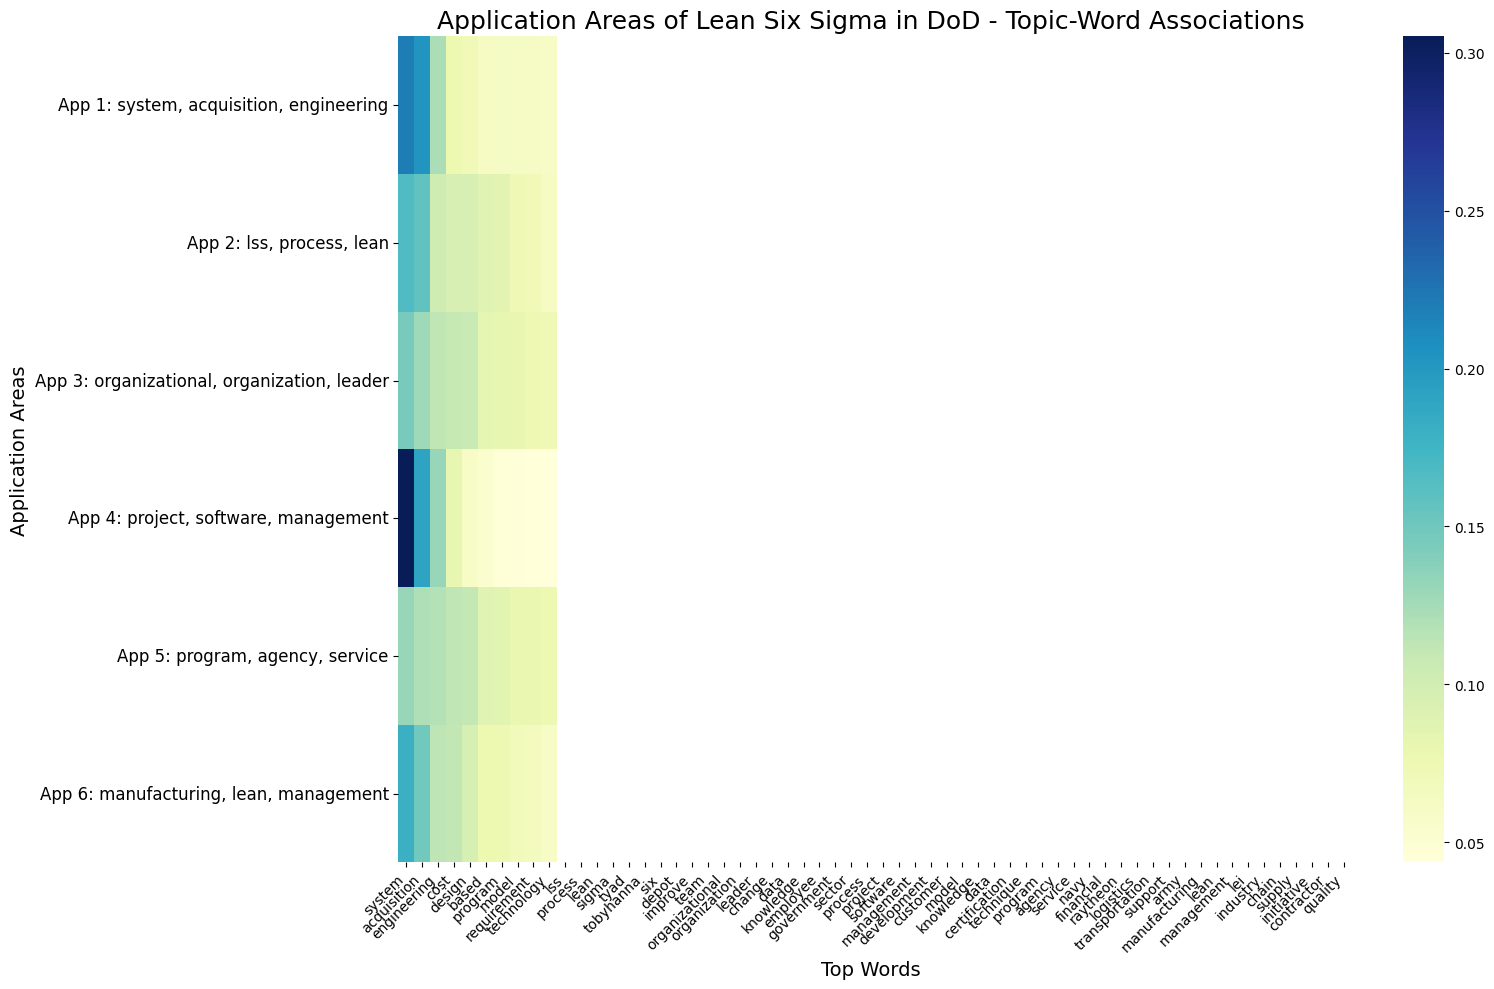

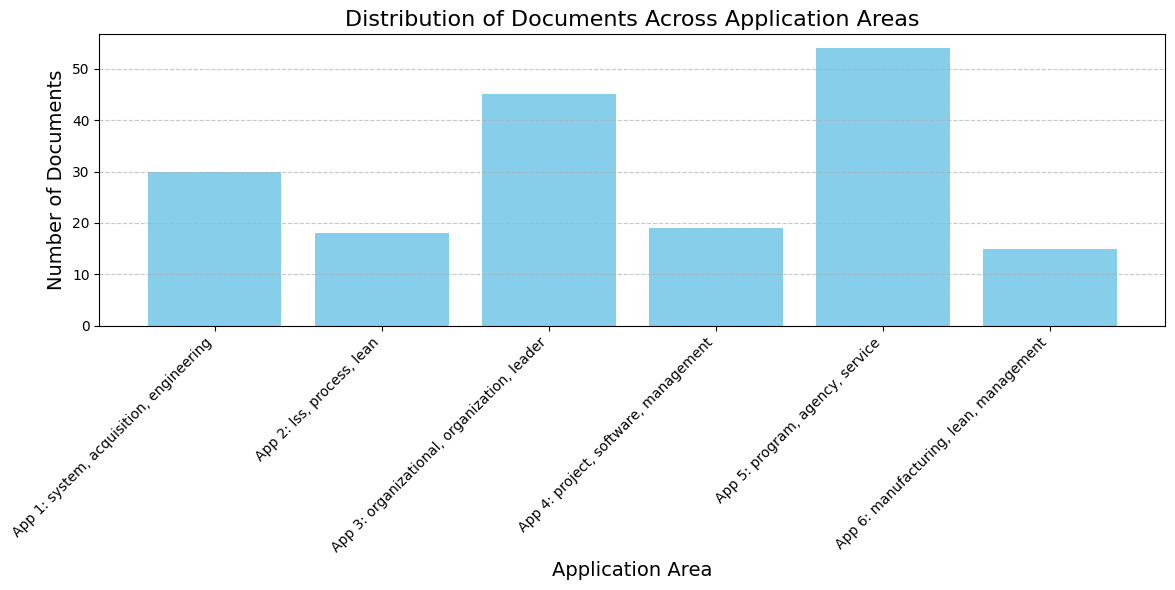

In [8]:

# Create TF-IDF vectorizer for application area identification
print("Performing first-stage topic modeling to identify application areas...")
application_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, max_features=1000)
application_tfidf = application_vectorizer.fit_transform(df['processed_abstract'])

# Determine optimal number of topics for application areas (typically fewer)
n_application_topics = 6  # Adjust based on your data and domain knowledge

# Apply NMF for application area identification
application_model = NMF(n_components=n_application_topics, random_state=42)
application_topics = application_model.fit_transform(application_tfidf)

# Get top words for each application topic
application_feature_names = application_vectorizer.get_feature_names_out()
application_topic_words = {}
for topic_idx, topic in enumerate(application_model.components_):
    top_indices = topic.argsort()[:-20-1:-1]  # Get top 20 words
    application_topic_words[topic_idx] = [application_feature_names[i] for i in top_indices]

# Create application topic labels using the top 3 words
application_topic_labels = []
for i in range(n_application_topics):
    application_topic_labels.append(f"App {i+1}: {', '.join(application_topic_words[i][:3])}")

# Assign documents to application topics
df['application_topic'] = application_topics.argmax(axis=1)
df['application_topic_score'] = application_topics.max(axis=1)

# Create heatmap of application topic-word associations
top_n_words = 10
application_word_matrix = np.zeros((n_application_topics, top_n_words))
application_word_labels = []

for i in range(n_application_topics):
    for j in range(top_n_words):
        application_word_matrix[i, j] = application_model.components_[i, np.argsort(-application_model.components_[i])[j]]
    
    # Normalize to improve visualization
    application_word_matrix[i] = application_word_matrix[i] / application_word_matrix[i].sum()
    application_word_labels.append([application_feature_names[idx] for idx in np.argsort(-application_model.components_[i])[:top_n_words]])

plt.figure(figsize=(16, 10))
sns.heatmap(application_word_matrix, annot=False, cmap="YlGnBu", 
            xticklabels=[application_word_labels[i][j] for i in range(n_application_topics) for j in range(top_n_words)],
            yticklabels=application_topic_labels)
plt.title("Application Areas of Lean Six Sigma in DoD - Topic-Word Associations", fontsize=18)
plt.xlabel("Top Words", fontsize=14)
plt.ylabel("Application Areas", fontsize=14)
plt.xticks(np.arange(0.5, top_n_words*n_application_topics, 1), 
           [word for topic in application_word_labels for word in topic], 
           rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig(f'{RESULTS_PATH}/application_topics_heatmap.png', dpi=300)

# Distribution of documents across application areas
application_distribution = np.zeros(n_application_topics)
for i in range(n_application_topics):
    application_distribution[i] = (df['application_topic'] == i).sum()

plt.figure(figsize=(12, 6))
bars = plt.bar(range(1, n_application_topics+1), application_distribution, color='skyblue')
plt.title('Distribution of Documents Across Application Areas', fontsize=16)
plt.xlabel('Application Area', fontsize=14)
plt.ylabel('Number of Documents', fontsize=14)
plt.xticks(range(1, n_application_topics+1), application_topic_labels, rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'{RESULTS_PATH}/application_distribution.png', dpi=300)